In [1]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2

### Read Dataset

In [2]:
ROOT = "./SDLane/train/"
DATALIST_PATH = os.path.join(ROOT, 'train_list.txt')

# Load datalist
with open(DATALIST_PATH) as f:
    datalist = [line.rstrip('\n') for line in f]  

In [3]:
def get_label(datalist, idx):
    """
    returns the corresponding label path for each image path
    """ 
    image_path = datalist[idx]
    label_path = image_path.replace('images', 'labels').replace('.jpg', '.json')
    return image_path, label_path

def load_json(label_path):
    with open(label_path, "r") as f:
        annotation = json.load(f)
    return annotation

image_path, label_path = get_label(datalist, idx=0)

# absolute path
image_path = os.path.join(ROOT, image_path)
label_path = os.path.join(ROOT, label_path)

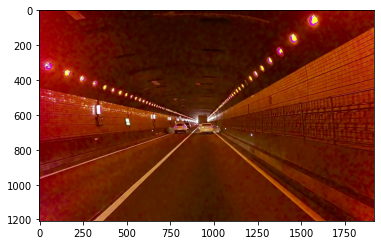

In [4]:
# visualize image
img = plt.imread(image_path)
plt.imshow(img)

In [5]:
# load raw annotation data
annotation = load_json(label_path) # key = ['geometry', 'idx']

### Visualize Segmentation Labels

In [6]:
def generate_seg_label(annotation, vis=None, height=1208, width=1920):
    """
    generates segmentation labels
    """ 
    if vis is None:
        vis = np.zeros((height, width, 3), dtype=np.uint8)
        vis = np.ascontiguousarray(vis)
        
    lane_geometry = annotation['geometry']
    pts = [np.int32(lane) for lane in lane_geometry if not len(lane)==0]
    vis = cv2.polylines(vis, pts, False, (255, 255, 255), 10)
    return vis

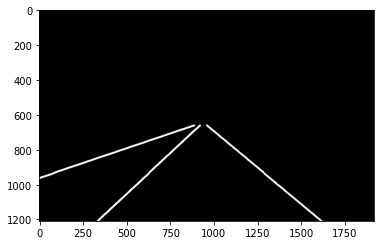

In [7]:
# visualize segmentation label
vis = generate_seg_label(annotation)
plt.imshow(vis)

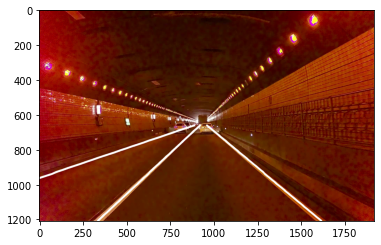

In [8]:
# overlay segmentation label on the original image 
vis = generate_seg_label(annotation, img)
plt.imshow(vis)

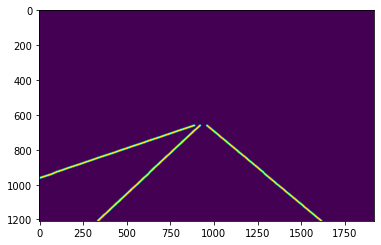

In [31]:
gray_img = cv2.cvtColor(vis, cv2.COLOR_BGR2GRAY)
# gray_img = gray_img.reshape(1, gray_img.shape[0], gray_img.shape[1])
if gray_img.max() > 1:
    gray_img = gray_img / 255
plt.imshow(gray_img)

## Test Dynamic Plot

In [26]:
import visdom
import numpy as np
!python -m visdom.server

In [29]:
visual = visdom.Visdom()
indx = np.array([0, 1, 2, 3, 4, 5, 6])
epoch_loss = np.array([0, 1, 2, 3, 5, 4, 7])
visual.line(X=indx, Y=epoch_loss, opts=dict(showlegend=True))

Setting up a new session...


'window_3c1655dab2a8b4'

## Save all the test & train segment json files to images files

#### Resize the image

In [ ]:
label_img = generate_seg_label(annotation)
resized_img_label = cv2.resize(label_img, (512, 512))
plt.imshow(resized_img_label)

img = plt.imread(image_path)
resized_img = cv2.resize(img, (512, 512))
plt.imshow(resized_img)

combined_img = np.concatenate((img, label_img), axis=1)
plt.imshow(combined_img)


In [29]:
def resize_img(img):
    return cv2.resize(img, (512, 512))

def save_image(fromIdx, toIdx, ROOT, datalist):    
    for i in range(fromIdx, toIdx):
        image_path, label_path = get_label(datalist, idx=i)
        image_path =  os.path.join(ROOT, image_path)
        label_path = os.path.join(ROOT, label_path)
        img = plt.imread(image_path)
        annotation = load_json(label_path) 
        lebel_img_path = label_path.replace('.json', '.jpg')
        lable_image = generate_seg_label(annotation)
        img = resize_img(img)
        lable_image = resize_img(lable_image)

        print("Save File to "+lebel_img_path)
        cv2.imwrite(lebel_img_path, lable_image)

        print("Save File to "+image_path)
        cv2.imwrite(image_path, img)

def create_multithread_save_files(ROOT, FILELIST, THREAD_NUM):
    DATALIST_PATH = os.path.join(ROOT, FILELIST)
    # Load datalist
    with open(DATALIST_PATH) as f:
        datalist = [line.rstrip('\n') for line in f]  

    threads = []
    datalistLength = len(datalist)
    for i in range(THREAD_NUM):
        threads.append(threading.Thread(target=save_image, args=(i*datalistLength//6, (i+1)*datalistLength//6, ROOT, datalist)))
        threads[i].start()

    for i in range(THREAD_NUM):
        threads[i].join()

    print("Finish")

In [ ]:
import threading

testAddr = "./SDLane/test/"
testList = 'test_list.txt'
trainAddr = "./SDLane/train/"
trainList = 'train_list.txt'

create_multithread_save_files(testAddr, testList, 24)
create_multithread_save_files(trainAddr, trainList, 24)
